In [ ]:
from glob import glob
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_theme()
import pandas as pd
import os

# ================================================================================================

import platform
import sys

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}\n")
print(f"OpenCV {cv2.__version__}")
print(f"Numpy {np.__version__}")
print(f"Matplotlib {matplotlib.__version__}")
print(f"Seaborn {sns.__version__}")
print(f"Pandas {pd.__version__}")

Python Platform: macOS-12.4-arm64-arm-64bit
Python 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:35:25) [Clang 16.0.6 ]

OpenCV 4.9.0
Numpy 1.26.4
Matplotlib 3.8.3
Seaborn 0.13.2
Pandas 2.2.0


In [ ]:
root = '_data/VOCdevkit/VOC2012/'
img_fold = root + 'JPEGImages/'
annot_dir = root + 'Annotations/'


### Read IMG files (JPEGImages/)

In [ ]:
# img_files = glob(root + 'JPEGImages/*.jpg')
img_files = os.listdir(root + 'JPEGImages/')
annot_files = os.listdir(root + 'Annotations/')

rows = []
for f in img_files[:]:

    # Read image
    img = cv2.imread(img_fold + f)

    # Get image shape
    fname = f.split('.')[0]
    ext = f.split('.')[1]

    # Append to rows
    rows.append([fname, ext, img.shape[0], img.shape[1], img.shape[2]])


# Create dataframe
df_img = pd.DataFrame(rows, columns=['fname', 'ext', 'height', 'width', 'channels'])

# Calculate image area
df_img["img_area"] = df_img["height"] * df_img["width"]
df_img.head()


,fname,ext,height,width,channels,img_area
0,2008_008336,jpg,375,500,3,187500
1,2007_000904,jpg,375,500,3,187500
2,2012_000760,jpg,375,500,3,187500
3,2009_004164,jpg,375,500,3,187500
4,2008_005612,jpg,375,500,3,187500


### Read Objects (Annotations/)

In [ ]:
voc_classes = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [ ]:
# Read and format data (extracted from given base notebook)
def read_content(xml_file: str):
    """Function to read XML file and return the list of objects and their bounding boxes."""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_objects = []
    for boxes in root.iter('object'):

        classname = boxes.find("name").text
        list_with_all_objects.append(voc_classes[classname])

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = round(float(boxes.find("bndbox/ymin").text))
        xmin = round(float(boxes.find("bndbox/xmin").text))
        ymax = round(float(boxes.find("bndbox/ymax").text))
        xmax = round(float(boxes.find("bndbox/xmax").text))

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return list_with_all_objects, list_with_all_boxes


In [ ]:

# Read all annotations and create a dataframe with class and bounding box coordinates
rows = []
for xml_file in annot_files[:]:

    # Read content
    cnames, bboxes = read_content(annot_dir + xml_file)
    fname = xml_file.split('.')[0]

    # Append each object to rows list
    for c, b in zip(cnames, bboxes):
        rows.append([fname, c, *b])

# Create dataframe
df_annot = pd.DataFrame(rows, columns=['fname', 'class', 'ymin', 'xmin', 'ymax', 'xmax'])

# Compute area of bounding box
df_annot['area'] = (df_annot['ymax'] - df_annot['ymin']) * (df_annot['xmax'] - df_annot['xmin'])

# Merge with image dataframe
df_annot = df_annot.merge(df_img[["fname", "img_area"]], on='fname', how='left')

# Calculate area ratio of each object
df_annot['area_ratio'] = df_annot['area'] / df_annot['img_area']
df_annot.head()

,fname,class,ymin,xmin,ymax,xmax,area,img_area,area_ratio
0,2011_006135,14,391,144,470,315,13509,187500,0.072048
1,2008_006482,8,155,321,233,411,7020,205500,0.034161
2,2008_006482,10,1,341,201,411,14000,205500,0.068127
3,2010_005054,19,86,34,121,70,1260,55500,0.022703
4,2010_005054,17,318,42,427,111,7521,55500,0.135514


In [ ]:
# xml_file = annot_dir + "2007_000027.xml" # => 1 object + 4 parts
# xml_file = annot_dir + "2007_000032.xml" # => 4 objects
# !cat $xml_file

### Results

In [ ]:
print("Objects count:", df_annot.shape[0])
# print("Images count:", df_annot['fname'].nunique())
print("Images count:", df_img.shape[0])

print("Area ratio total mean:", df_annot['area_ratio'].mean())
print("Area ratio total variance:", df_annot['area_ratio'].var())
# print("Area ratio max:", df_annot['area_ratio'].max())
# print("Area ratio min:", df_annot['area_ratio'].min())
# print("Area ratio std:", df_annot['area_ratio'].std())

print("\nArea ratio per class:")
print("---------------------------------------------")
print("{:<3} {:<15} {:<8} {:<8} {:<8}".format("", "Class", "Mean", "Var", "Std"))
print("---------------------------------------------")
for cname, c in voc_classes.items():
    area_ratio = df_annot[df_annot['class'] == c]['area_ratio']
    print(f"{c:<3} {cname:<15} {area_ratio.mean():<8.4f} {area_ratio.var():<8.4f} {area_ratio.std():<8.4f}")



Objects count: 40138
Images count: 17125
Area ratio total mean: 0.20813015103576907
Area ratio total variance: 0.05996628005942527

Area ratio per class:
---------------------------------------------
    Class           Mean     Var      Std     
---------------------------------------------
0   aeroplane       0.2828   0.0716   0.2675  
1   bicycle         0.2644   0.0815   0.2854  
2   bird            0.1809   0.0478   0.2186  
3   boat            0.1464   0.0478   0.2186  
4   bottle          0.0641   0.0173   0.1317  
5   bus             0.2932   0.0669   0.2587  
6   car             0.1414   0.0537   0.2317  
7   cat             0.4686   0.0798   0.2824  
8   chair           0.1215   0.0324   0.1799  
9   cow             0.1778   0.0556   0.2358  
10  diningtable     0.2890   0.0557   0.2360  
11  dog             0.3603   0.0753   0.2745  
12  horse           0.2918   0.0635   0.2521  
13  motorbike       0.3271   0.0869   0.2947  
14  person          0.1965   0.0495   0.2225  
15

In [ ]:
# cnames = list(voc_classes.keys())
# df_annot['cnames'] = df_annot['class'].apply(lambda x: cnames[x])
# # df_annot['class'].apply(lambda x: cnames[x]).value_counts().plot(kind='bar', title='Object count by class')

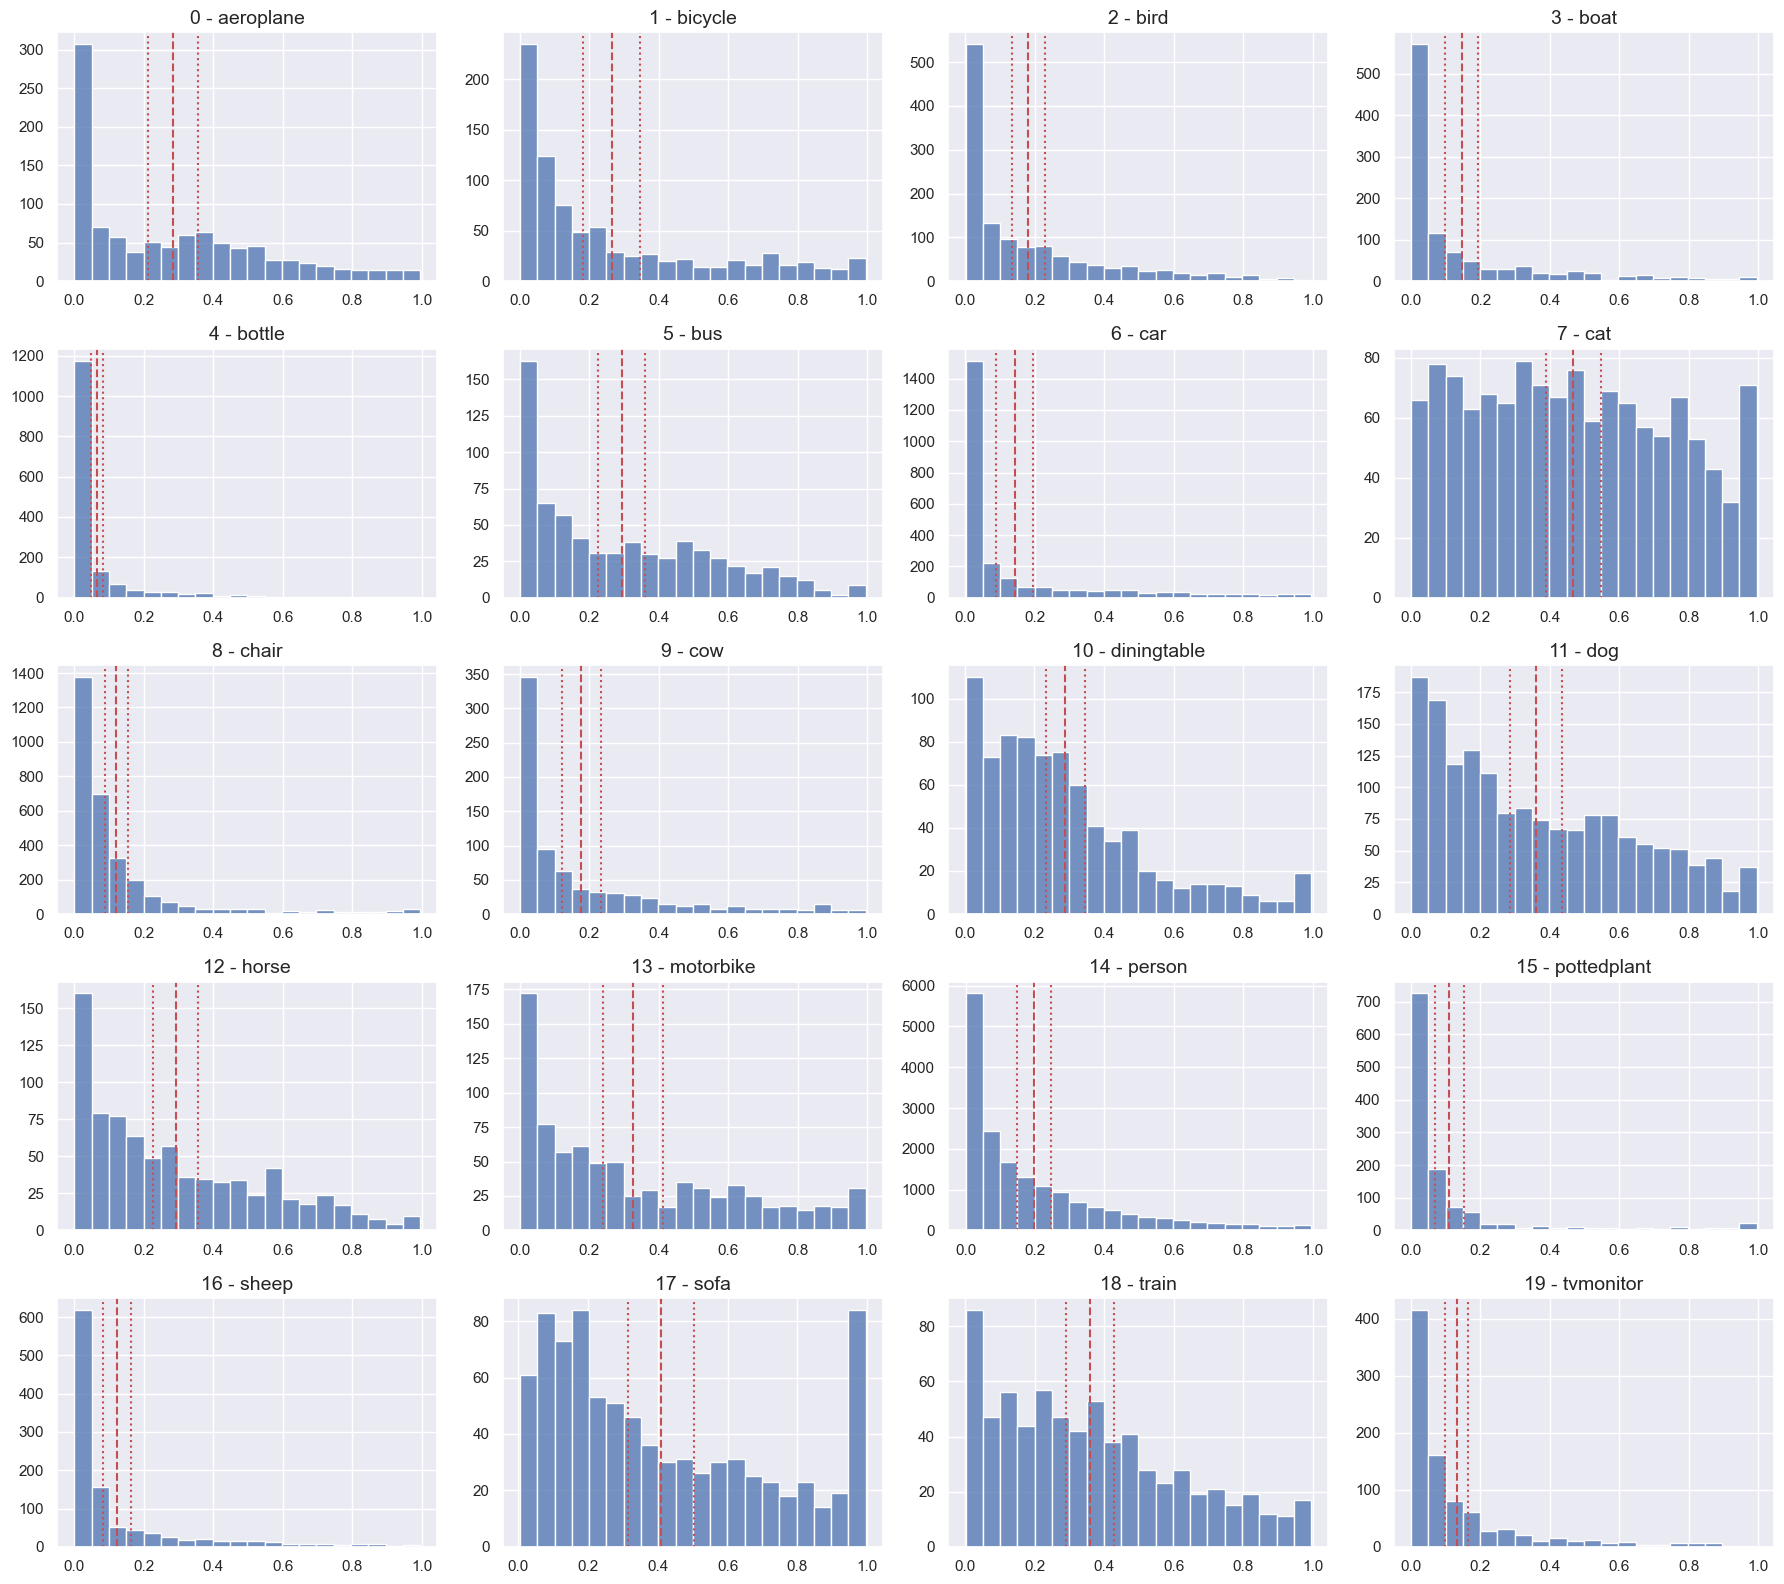

In [ ]:
# Plot area ratio distribution
fig, axs = plt.subplots(5, 4, figsize=(18,16))
ax = axs.ravel()

# sns.histplot(df_annot['area_ratio'], bins=20, ax=ax)
for cname, c in voc_classes.items():
    area_ratio = df_annot[df_annot['class'] == c]['area_ratio']

    sns.histplot(area_ratio, bins=20, ax=ax[c])

    # Plot mean and variance lines
    ax[c].axvline(area_ratio.mean(), color='r', linestyle='--')
    ax[c].axvline(area_ratio.mean() + area_ratio.var(), color='r', linestyle=':')
    ax[c].axvline(area_ratio.mean() - area_ratio.var(), color='r', linestyle=':')

    ax[c].set_title(f"{c} - {cname}", fontsize=14)
    ax[c].set_xlabel('')
    ax[c].set_ylabel('')

plt.title("Area ratio distribution of each class")
plt.tight_layout()

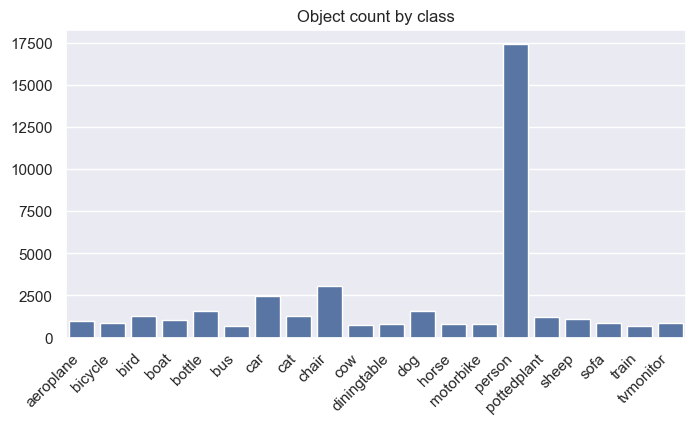

In [ ]:
# Plot unbalanced data
classes, counts = np.unique(df_annot['class'], return_counts=True)

fig, ax = plt.subplots(figsize=(8,4))
sns.barplot(x=classes, y=counts)

# Set x labels to class names
# plt.xticks(classes, voc_classes.keys(), rotation=90);
plt.xticks(classes, voc_classes.keys(),  rotation=45, horizontalalignment='right')
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title('Object count by class')
plt.show()


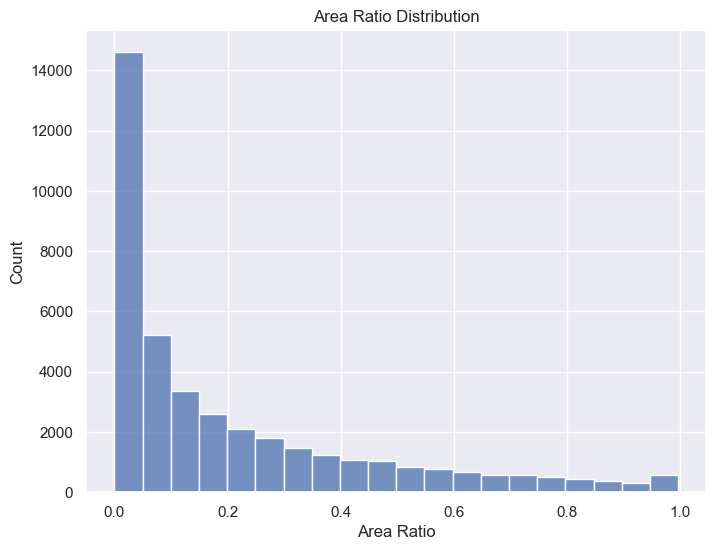

In [ ]:
# Plot area ratio distribution
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_annot['area_ratio'], bins=20, ax=ax)

ax.set_xlabel('Area Ratio')
ax.set_ylabel('Count')
ax.set_title('Area Ratio Distribution')
plt.show()